In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def my_linsolver(A, b):
    A = A.astype('float64')
    b = b.astype('float64')
    nrows = A.shape[0]
    # Creating the augmented matrix.
    # This is done so it's easy to solve the system
    # using simple elimination steps without
    # having to alter a separate vector. 
    A = np.hstack([A, b])

    # Creating the solution vector:
    solvec = np.zeros([nrows, 1])
    # Backward elimination loop. One loop is vectorized
    # Using Numpy slice notation.
    # Looping over all rows except last one.
    # This loop is the outermost loop
    # using which the multipliers are calculated.
    for rownum in range(nrows):

        # All rows below the current row
        # in which the elements below the diagonal element
        # are being zeroed out.
        for rownum_below in range(rownum+1, nrows):

            # Calculating the multipliers for each row
            # to zero out all elements in the column
            # below the row A[rownum, :]
            # These are used later for LU decompositionsteps.
            multiplier = A[rownum_below, rownum]/A[rownum, rownum]

            # Debug print.
            # print(multiplier)

            # Eliminating all rows below A[rownum, :]
            A[rownum_below, :] -= multiplier*A[rownum, :]

        # Forcing all eliminated elements to 0.
        # This is done to prevent roundoff blowup.
        # Just in case.
        A[rownum+1:, rownum] = 0
    # print(A)

    # Returning to matrix and vector separately.
    b = A[:, -1]
    A = A[:, :-1]
    # Backsubstitution loop.
    # The outermost loop goes from the last row
    # to the second row.
    for rownum in range(nrows-1, -1, -1):
        solvec[rownum, 0] = (b[rownum]-\
              np.sum(A[rownum, rownum+1:]*solvec[rownum+1:, 0]))\
        /A[rownum, rownum]

    # Returning the solution vector.
    return solvec

In [3]:
# Solving system 1.
A1 = np.array([[3, 1, 4],
              [0, 1, -2],
              [1, 2, -1]])
b1 = np.array([[6, -3, -2]]).T
x1 = my_linsolver(A1, b1)
print("Solution is:\n", x1)

Solution is:
 [[ 1.]
 [-1.]
 [ 1.]]


In [4]:
# Solving system 2.
A2 = np.array([[1, 1, 0, 1],
              [2, 1, -1, 1],
              [4, -1, -2, 2],
              [3, -1, -1, 1]])

b2 = np.array([[2, 1, 0, -3]]).T

x2 = my_linsolver(A2, b2)
print('Solution:\n', x2)
print('||b2-A2x2||:\n', np.linalg.norm(b2-np.dot(A2, x2)))

Solution:
 [[-2.66666667]
 [ 0.66666667]
 [-1.66666667]
 [ 4.        ]]
||b2-A2x2||:
 1.9860273226e-15


In [10]:
def my_linsolver_lu(A, b):
    
    nrows = A.shape[0]
    A = A.astype('float64')
    b = b.astype('float64')
    # Ac, bc = A.copy(), b.copy()
    
    L = np.eye(nrows)

    # Backward elimination loop. One loop is vectorized
    # using Numpy slice notation.
    # Looping over all rows except last one.
    # This loop is the outermost loop.
    for rownum in range(nrows):

        # All rows below the current row
        # in which the elements below the diagonal element
        # are being zeroed out.
        for rownum_below in range(rownum+1, nrows):

            # Calculating the multipliers for each row
            # to zero out all elements in the column
            # below the row A[rownum, :]
            # These are used later for LU decompositionsteps.
            multiplier = A[rownum_below, rownum]/A[rownum, rownum]
            L[rownum_below, rownum] = multiplier
            # Debug print.
            # print(multiplier)

            # Eliminating all rows below A[rownum, :]
            A[rownum_below, :] -= multiplier*A[rownum, :]

        # Forcing all eliminated elements to 0.
        # This is done to prevent roundoff blowup.
        # Just in case.
        A[rownum+1:, rownum] = 0
    
    U = A[:, :nrows]
    yvec = np.zeros([nrows, 1])
    solvec = np.zeros([nrows, 1])
    
    # Forward substitution of the Ly = b problem.
    for rownum in range(nrows):
        yvec[rownum, 0] = (b[rownum]-\
            np.sum(L[rownum, :rownum]*yvec[:rownum, 0]))\
        /L[rownum, rownum]
        
    # print("y numpy", np.linalg.solve(L, b)-yvec.T)
    
    # Backward substitution of the Ux = y problem.
    for rownum in range(nrows-1, -1, -1):
        solvec[rownum, 0] = (yvec[rownum]-\
              np.sum(U[rownum, rownum+1:]*solvec[rownum+1:, 0]))\
        /U[rownum, rownum]
        
    print(L, '\n\n', U)
    
    return solvec

In [11]:
x2_lu = my_linsolver_lu(A2, b2)
x2 = np.linalg.solve(A2, b2)
print(x2_lu, '\n')
print(np.linalg.norm(x2-x2_lu))

[[ 1.  0.  0.  0.]
 [ 2.  1.  0.  0.]
 [ 4.  5.  1.  0.]
 [ 3.  4.  1.  1.]] 

 [[ 1.  1.  0.  1.]
 [ 0. -1. -1. -1.]
 [ 0.  0.  3.  3.]
 [ 0.  0.  0. -1.]]
[[-2.66666667]
 [ 0.66666667]
 [-1.66666667]
 [ 4.        ]] 

5.97873396028e-16


In [7]:
def trisolve(ldiag, diag, udiag, f):
    
    # The number of elements in the main diagonal.
    n = len(diag)
    Ldiag = np.zeros(n)
    # The lower diagonal elements start from b2
    Ldiag[1:] = ldiag
    Udiag = np.zeros(n)
    
    # The upper diagonal elements end at c_n-1
    Udiag[:-1] = udiag
    Mdiag = diag
    
    # The main diagonal of L is ones.
    # The lower diagonal of L is Lvec.
    # The main diagonal of U is Uvec.
    # The upper diagonal of U is Udiag
    # Setting the first components of the vectors
    # and looping from the second component.
    Lvec, Uvec = np.zeros(n), np.zeros(n)
    Lvec[0], Uvec[0] = 0, diag[0]
    
    # Solver loop. 
    for i in range(1, n):
        Lvec[i] = Ldiag[i]/Uvec[i-1]
        Uvec[i] = Mdiag[i] - Lvec[i]*Udiag[i-1]
        
    # The three lines below can be uncommented.
    # to verify the LU decomposition.
    # L = np.diagflat(Lvec[1:], -1)+np.eye(n)
    # U = np.diagflat(Udiag[:-1], 1)+np.diagflat(Uvec, 0)
    #print(L@U)
    
    yvec = np.zeros([n])
    yvec[0] = f[0]
    for i in range(1, n):
        yvec[i] = f[i] - Lvec[i]*yvec[i-1]
        
    xvec = np.zeros([n])
    xvec[-1] = yvec[-1]/Uvec[-1]
    for i in range(n-2, -1, -1):
        xvec[i] = (yvec[i]-Udiag[i]*xvec[i+1])/Uvec[i]
    
    # print(xvec)
    return xvec

sol = trisolve(np.array([-1,-1,-1,-1]), 
         np.array([2, 2, 2, 2, 2]), 
         np.array([-1,-1,-1,-1]), 
         np.array([1,0,0,0,1]))

print('Solution:\n', sol)

Solution:
 [ 1.  1.  1.  1.  1.]


In [8]:
p = 24
x = np.linspace(0, 1, p)
h = x[1]-x[0]
l, u = np.zeros(p-1)+1, np.zeros(p-1)+1
d = np.zeros(p)-2-h*h
sol = trisolve(l, d, u, h*h*x)

Norm:
 0.0480489493857


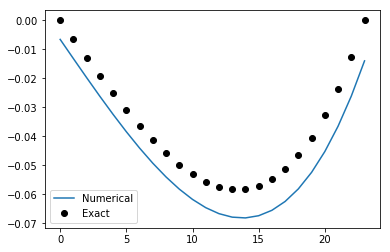

In [9]:
plt.plot(sol)
solexact = np.exp(1)/(np.exp(1)**2-1)*(np.exp(x)-np.exp(-x))-x
plt.plot(solexact, 'ko', markevery=int(p/50+1))
print('Norm:\n', np.linalg.norm(solexact-sol))
plt.legend(['Numerical', 'Exact'])